In [32]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
# import geopandas as gpd
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# import time
import seaborn as sns
from xgboost import XGBClassifier



## 2. Data Loading and Exploration

In [33]:
url="https://raw.githubusercontent.com/metropolisjenensis/data_for_prob_ML/refs/heads/main/weatherAUS.csv"
df= pd.read_csv(url, encoding='utf-8')

In [34]:
df.shape

(145460, 23)

In [35]:
df["Sunshine"].value_counts()

Sunshine
0.0     2359
10.7    1101
11.0    1094
10.8    1069
10.5    1027
        ... 
14.0      15
14.1       6
14.3       4
14.2       2
14.5       1
Name: count, Length: 145, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [37]:
# find out how many days it did rained
rain_days_count = df['RainTomorrow'].value_counts().get('Yes', 0)
rain_days_count

31877/df.shape[0]

0.21914615701911178

In [38]:
df['Location'].value_counts().shape

(49,)

In [39]:
start_date= df['Date'].min()
end_date= df['Date'].max()
print(f"The dates range from {start_date} to {end_date}.")

The dates range from 2007-11-01 to 2017-06-25.


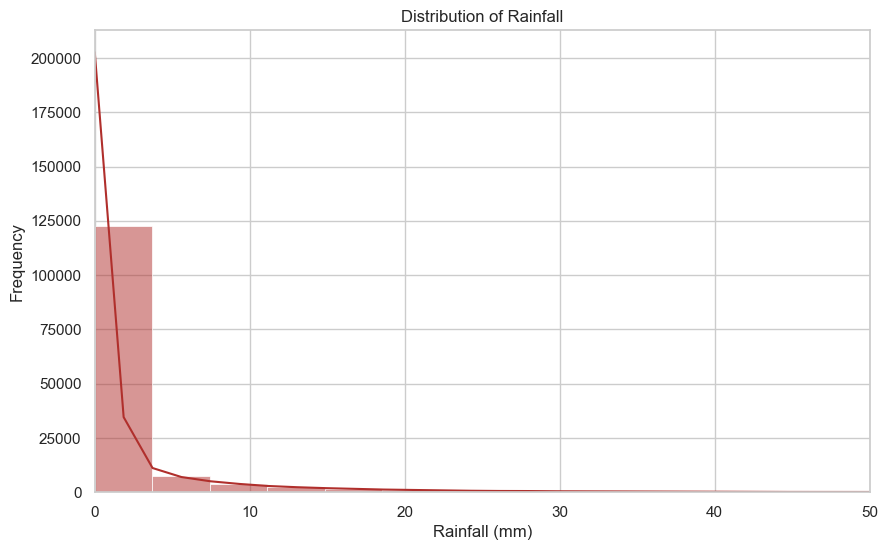

In [40]:
sns.set(style="whitegrid")

# 1. Distribution of Rainfall
plt.figure(figsize=(10, 6))
sns.histplot(df['Rainfall'].dropna(), bins=100, kde=True ,color='#B02F2C')
plt.title("Distribution of Rainfall")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.xlim(0, 50)  # Focus on typical range
plt.show()

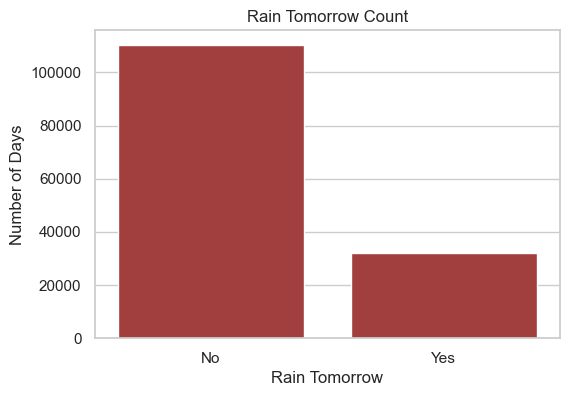

In [41]:
# 2. Count of Rain days vs Non-Rain Days
plt.figure(figsize=(6, 4))
sns.countplot(x='RainTomorrow', data=df ,color='#B02F2C')
plt.title("Rain Tomorrow Count")
plt.xlabel("Rain Tomorrow")
plt.ylabel("Number of Days")
plt.show()

In [42]:
#transform the date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

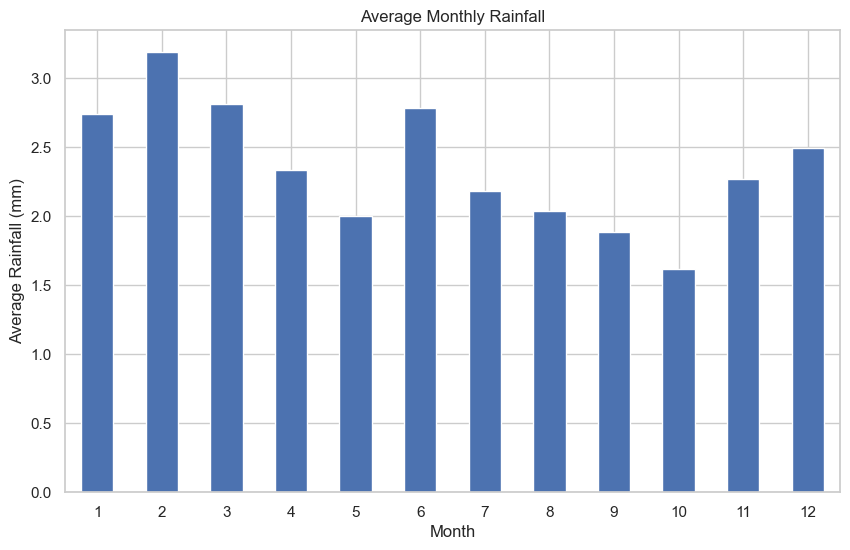

In [43]:
# 3. Average Monthly Rainfall
monthly_rain = df.groupby(df['Date'].dt.month)['Rainfall'].mean()

plt.figure(figsize=(10, 6))
monthly_rain.plot(kind='bar')
plt.title("Average Monthly Rainfall")
plt.xlabel("Month")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(rotation=0)
plt.show()

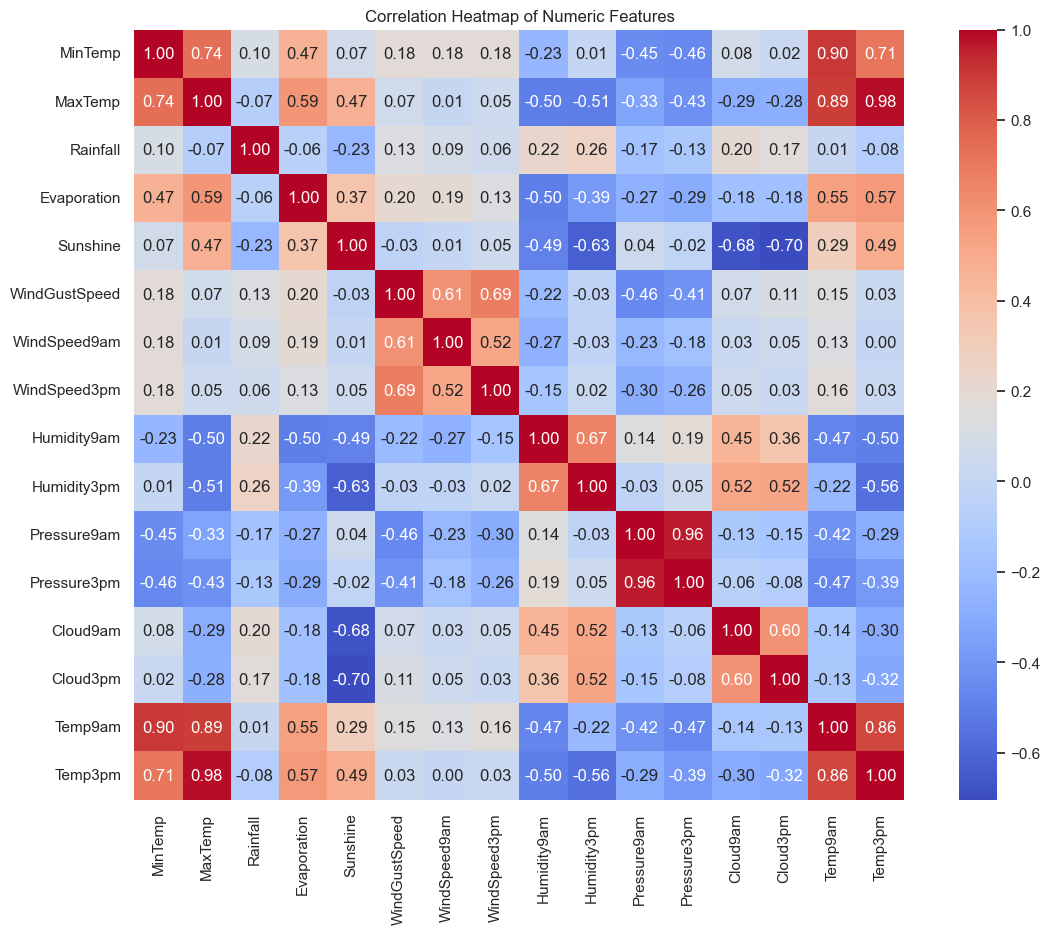

In [44]:
plt.figure(figsize=(14, 10))
numeric_df = df.select_dtypes(include=['float64'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [45]:
df_queensland_floating = df[(df['Location'] == 'Brisbane') & ((df["Date"].dt.year == 2010)|(df["Date"].dt.year == 2011)) & (df["Rainfall"] > 50)]

In [46]:
df_queensland_floating


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
84593,2010-02-07,Brisbane,22.3,26.7,89.0,8.2,0.1,SSE,30.0,SSE,...,90.0,73.0,1017.7,1015.8,8.0,8.0,22.3,26.0,Yes,No
84603,2010-02-17,Brisbane,21.3,28.3,121.4,4.2,0.7,ESE,24.0,SSW,...,85.0,65.0,1013.8,1012.0,8.0,8.0,22.6,27.4,Yes,No
84616,2010-03-02,Brisbane,20.9,23.9,60.6,3.2,0.0,ESE,37.0,E,...,93.0,91.0,1010.5,1008.2,8.0,8.0,21.1,21.9,Yes,Yes
84778,2010-08-11,Brisbane,16.1,19.0,78.0,8.4,2.1,W,28.0,NW,...,89.0,51.0,1014.7,1011.1,8.0,7.0,16.9,17.7,Yes,No
84836,2010-10-08,Brisbane,18.5,22.6,54.0,4.2,0.0,SE,43.0,SSW,...,85.0,81.0,1019.1,1017.1,8.0,8.0,21.3,21.1,Yes,Yes
84839,2010-10-11,Brisbane,15.1,22.2,93.6,13.0,0.0,E,37.0,ESE,...,90.0,89.0,1026.2,1024.8,8.0,8.0,19.1,19.6,Yes,Yes
84891,2010-12-02,Brisbane,19.5,26.9,58.6,6.4,0.5,NE,28.0,NNE,...,84.0,72.0,1016.8,1015.2,8.0,7.0,23.1,24.3,Yes,Yes
84894,2010-12-05,Brisbane,19.6,26.1,50.6,4.2,1.2,E,28.0,SE,...,94.0,72.0,1010.4,1008.1,8.0,7.0,21.0,24.9,Yes,No
84901,2010-12-12,Brisbane,20.4,27.2,80.4,12.4,0.0,W,15.0,NW,...,81.0,86.0,1008.8,1006.9,8.0,8.0,23.9,23.7,Yes,Yes
84909,2010-12-20,Brisbane,17.3,28.1,57.4,3.8,12.3,W,48.0,W,...,64.0,31.0,1002.6,1003.6,7.0,1.0,24.1,27.2,Yes,No


84603	2010-02-17	Brisbane	21.3	28.3	121.4
news page to blitz floods

84930	2011-01-10	Brisbane	22.5	27.1	110.8
part of the floods in queensland

In [47]:
df[df["Rainfall"] == df["Rainfall"].max()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
9368,2009-11-07,CoffsHarbour,17.4,23.1,371.0,NaN,3.5,NaN,NaN,SW,...,93.0,81.0,1026.6,1025.9,8.0,5.0,18.6,22.0,Yes,Yes


The maximum case of rainfall is also linked to floods in Coffs Harbour, NSW, Australia.

In [48]:
# Drop columns with too many missing values
threshold = 0.3  # 30% missing allowed
df_clean = df.loc[:, df.isnull().mean() < threshold]

In [49]:
df_clean.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [50]:
# Drop rows with missing target
df_clean = df_clean.dropna(subset=["RainTomorrow"])

In [51]:
# Encode target variable
df_clean["RainTomorrow"] = df_clean["RainTomorrow"].map({"No": 0, "Yes": 1})


In [52]:
# Drop 'Date' (not useful for this task)
df_clean = df_clean.drop(columns=["Date"])



In [53]:
# Fill missing numerical values with column median
for col in df_clean.select_dtypes(include=[np.number]).columns:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)



C:\Users\konst\AppData\Local\Temp\ipykernel_7112\1403100184.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
C:\Users\konst\AppData\Local\Temp\ipykernel_7112\1403100184.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


Here comes the code, that generated the plot for the weather stations in australia.


In [54]:


# # List of weather station names from weatherAUS.csv
# locations = [
#     'Albury', 'Badgerys Creek', 'Cobar', 'Coffs Harbour', 'Moree', 'Newcastle', 'Norah Head', 'Norfolk Island', 'Penrith',
#     'Richmond', 'Sydney', 'Sydney Airport', 'Wagga Wagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong',
#     'Mount Ginini', 'Ballarat', 'Bendigo', 'Sale', 'Melbourne Airport', 'Melbourne', 'Mildura', 'Nhil', 'Portland',
#     'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'Gold Coast', 'Townsville', 'Adelaide', 'Mount Gambier',
#     'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'Pearce RAAF', 'Perth Airport', 'Perth', 'Salmon Gums', 'Walpole',
#     'Hobart', 'Launceston', 'Alice Springs', 'Darwin', 'Katherine', 'Uluru'
# ]

# # Initialize geocoder
# geolocator = Nominatim(user_agent="weatherAUS_geocoder")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# # Create DataFrame
# df = pd.DataFrame(locations, columns=["Location"])
# df["Latitude"] = None
# df["Longitude"] = None

# # Query each location
# for idx, loc in df.iterrows():
#     try:
#         place = geocode(f"{loc['Location']}, Australia")
#         if place:
#             df.at[idx, "Latitude"] = place.latitude
#             df.at[idx, "Longitude"] = place.longitude
#         else:
#             print(f"⚠️ No result for {loc['Location']}")
#     except Exception as e:
#         print(f"❌ Error for {loc['Location']}: {e}")
#     time.sleep(1.1)  # avoid throttling

# # Save results
# df.to_csv("weather_station_coordinates.csv", index=False)
# print("✅ Done. Saved to 'weather_station_coordinates.csv'")

In [55]:
# df = pd.read_csv("weather_station_coordinates.csv").dropna(subset=["Latitude", "Longitude"])
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]))

# # Load downloaded Natural Earth shapefile (adjust the path if needed)
# world = gpd.read_file("C:/Users/konst/Probabilistic-Machine-Learning_lecture-PROJECTS\projects/09-1AKXXXX_rain_tomorrow_prediction/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
# australia = world[world["ADMIN"] == "Australia"]

# # Plot
# fig, ax = plt.subplots(figsize=(12, 10))
# australia.plot(ax=ax, color="lightgrey", edgecolor="black")
# gdf.plot(ax=ax, color="red", markersize=50)

# # Annotate each point
# for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["Location"]):
#     ax.text(x + 0.5, y + 0.2, label, fontsize=8)

# plt.title("Australian Weather Observation Stations")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.tight_layout()
# plt.grid(True)
# plt.show()

In [56]:
# Encode categorical features
cat_cols = df_clean.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))



In [57]:
# Split features and target
X = df_clean.drop(columns=["RainTomorrow"])
y = df_clean["RainTomorrow"]


In [58]:

# Standardize features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((113754, 17), (28439, 17))

In [59]:

# Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_test)

# Evaluate both models
xgb_preds = np.argmax(xgb_preds, axis=1)
xgb_cm = confusion_matrix(y_test, xgb_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)

lr_preds = np.argmax(lr_preds, axis=1)
lr_cm = confusion_matrix(y_test, lr_preds)
lr_acc = accuracy_score(y_test, lr_preds)
lr_report = classification_report(y_test, lr_preds, output_dict=True)


c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:58:45] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


confusion matrix plot


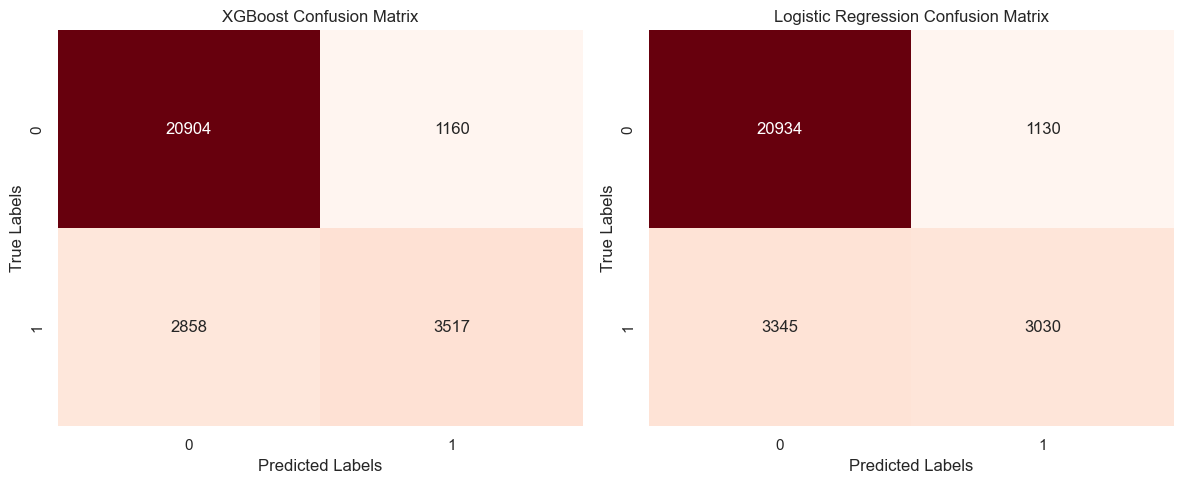

In [60]:
# Plotting function
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False, ax=ax)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title(title)

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(xgb_cm, "XGBoost Confusion Matrix", axes[0])
plot_confusion_matrix(lr_cm, "Logistic Regression Confusion Matrix", axes[1])

plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute metrics for XGBoost
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)

# Compute metrics for Logistic Regression
lr_precision = precision_score(y_test, lr_preds)
lr_recall = recall_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)


print("XGBoost Metrics:")
print("Precision:",xgb_precision)
print("Recall:",xgb_recall)
print("F1:",xgb_f1)

print("Logistic Regression Metrics:")
print("Precision:",lr_precision)
print("Recall:",lr_recall)
print("F1:",lr_f1)

XGBoost Metrics:
Precision: 0.7519777635236262
Recall: 0.5516862745098039
F1: 0.6364458921462178
Logistic Regression Metrics:
Precision: 0.7283653846153846
Recall: 0.4752941176470588
F1: 0.5752254390128144


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefs]


c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1351 seconds.
There were 8000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
c:\Users\konst\miniconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single va

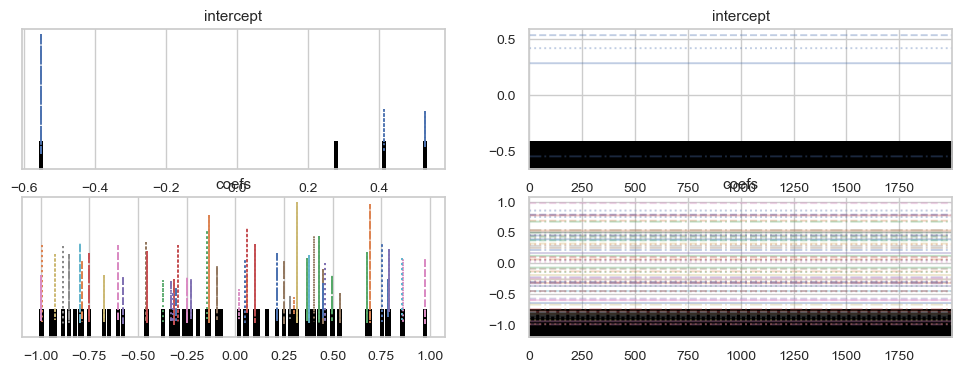

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.169  0.425    -0.551      0.532      0.212    0.117       4.0   
coefs[0]   0.100  0.513    -0.651      0.787      0.256    0.125       4.0   
coefs[1]  -0.510  0.409    -0.992      0.060      0.204    0.071       4.0   
coefs[2]   0.169  0.344    -0.373      0.497      0.171    0.078       4.0   
coefs[3]  -0.325  0.317    -0.794      0.100      0.158    0.079       4.0   
coefs[4]   0.296  0.376    -0.230      0.790      0.188    0.080       5.0   
coefs[5]  -0.007  0.370    -0.461      0.450      0.184    0.048       4.0   
coefs[6]   0.161  0.799    -0.948      0.977      0.398    0.120       4.0   
coefs[7]  -0.239  0.636    -0.886      0.503      0.317    0.039       4.0   
coefs[8]  -0.369  0.477    -0.927      0.319      0.238    0.092       5.0   
coefs[9]  -0.005  0.655    -0.798      0.855      0.327    0.099       4.0   
coefs[10]  0.321  0.388    -0.307      0.752      0.193    0.102

In [62]:
import pymc as pm
import arviz as az
# Standardisierung
X_standardized = (X - X.mean()) / X.std()
X_values = X_standardized.values
y_values = y.values

# Bayesian Logistic Regression mit PyMC
with pm.Model() as logistic_model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    coefs = pm.Normal("coefs", mu=0, sigma=5, shape=X_values.shape[1])

    # Logits
    logits = intercept + pm.math.dot(X, coefs)

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y_values)

    # Inferenz (Sampling mit NUTS)
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Ergebnisse visualisieren
az.plot_trace(trace)
plt.show()

# Posterior-Zusammenfassung
print(az.summary(trace, hdi_prob=0.95))

## Clustering 

In [63]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign cluster labels back to the DataFrame
X_clustered = X.copy()
X_clustered['DayType'] = clusters



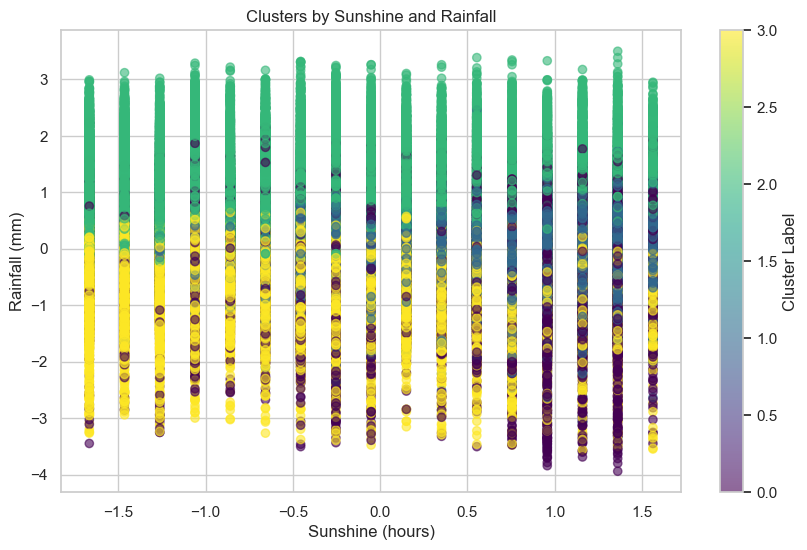

In [64]:



features = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
    'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'
]


# Extract the two features for visualization
sun_scaled = X_scaled[:, features.index('Sunshine')]
rain_scaled = X_scaled[:, features.index('Rainfall')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(sun_scaled, rain_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Sunshine and Rainfall')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Rainfall (mm)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

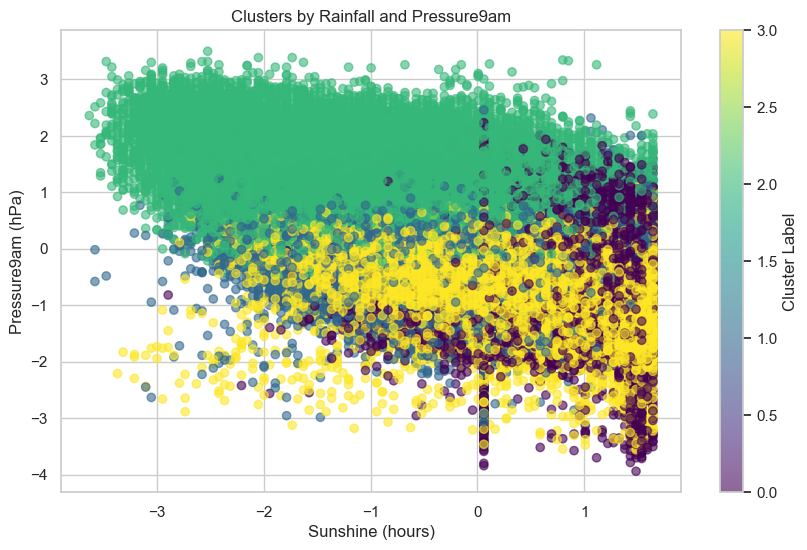

In [65]:
# Extract the two features for visualization
pressure9a_scaled = X_scaled[:, features.index('Pressure9am')]
rain_scaled = X_scaled[:, features.index('Rainfall')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(pressure9a_scaled, rain_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Rainfall and Pressure9am')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Pressure9am (hPa)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

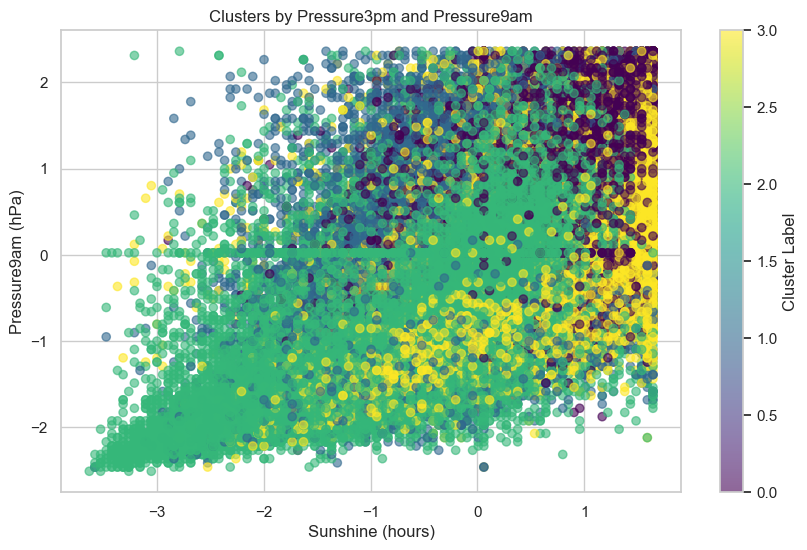

In [66]:
# Extract the two features for visualization
pressure9a_scaled = X_scaled[:, features.index('Pressure9am')]
pressure3pm_scaled = X_scaled[:, features.index('Pressure3pm')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(pressure9a_scaled, pressure3pm_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Pressure3pm and Pressure9am')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Pressure9am (hPa)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

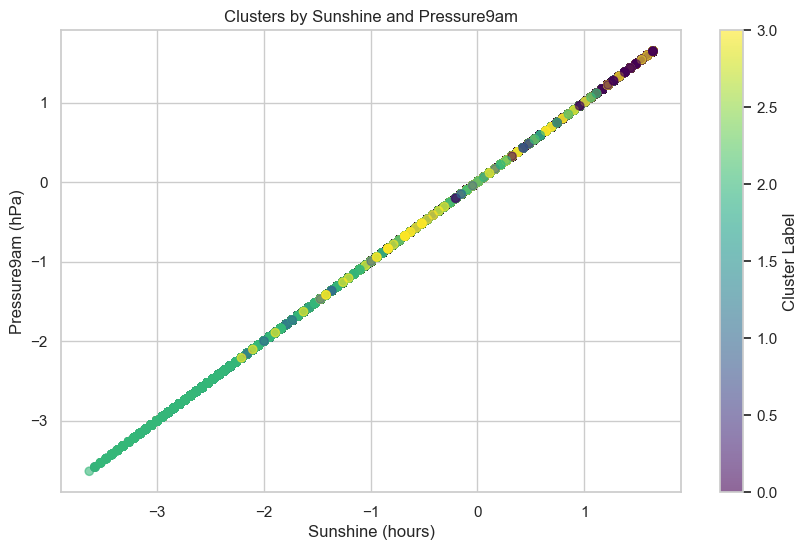

In [67]:
# Extract the two features for visualization
pressure9a_scaled = X_scaled[:, features.index('Pressure9am')]
sun_scaled = X_scaled[:, features.index('Pressure9am')]

# Scatter plot: Sunshine vs. Rainfall colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(pressure9a_scaled, sun_scaled, c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters by Sunshine and Pressure9am')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Pressure9am (hPa)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()